In [36]:
import matplotlib.pyplot as plt
import numpy
import seaborn
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

color_palette = seaborn.color_palette("deep")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Lucida Grande', 'Verdana']  # example sans-serif fonts
plt.rcParams['font.size'] = 9

In [37]:
benchmark_directory = 'i-pi-paper-benchmarks/'

code_version = ['main', 'v2.6.1']

system_size = [8, 64, 512, 4096, 32768]
system_size = [str(s).zfill(5) for s in system_size]

# Property-Trajectory print modes
output_modes = ['Pn_Tn', 'Py_Tn', 'Pn_Ty', 'Py_Ty']

# i-PI overhead

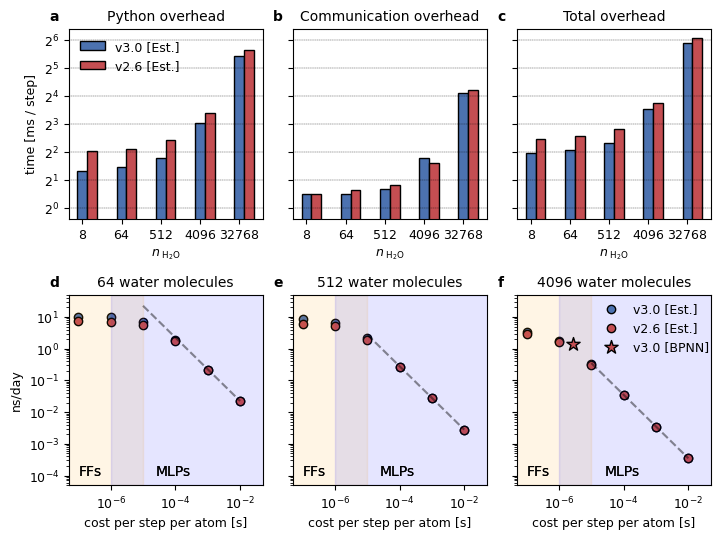

In [75]:
simulation_modes = ['npt-lmp-ideal-gas', 'npt-i-pi-no-interface', 'npt-i-pi-ideal-gas-interface', 'npt-i-pi-lmp-interface']

version = code_version[0]

all_data = {}

colors = [color_palette[0], color_palette[3]]
labels = ['v3.0 [Est.]', 'v2.6 [Est.]']

for version in code_version:

    all_data[version] = []
    data_list = all_data[version]
    for mode in simulation_modes:
        dir = benchmark_directory + version + '/' + mode + '/' 
        data = numpy.loadtxt(dir + '/' + output_modes[0] + '.txt')
        data_list.append(data)

fig, ax = plt.subplots(2, 3, figsize=(3.65 * 2, 3.65 * 1.5))

# UPPER PANEL

axs = ax[0]

for index, version in enumerate(code_version):

    data_list = all_data[version]
    system_size = data_list[0][:,0] * 3
    python_overhead = (data_list[1][:, 1] - data_list[0][:, 1])
    communication = (data_list[2][:, 1] - data_list[1][:, 1]) 

    axs[0].bar(x=numpy.asarray(range(len(system_size))) + 0.25 * index, height = (python_overhead) * 1000, width=0.25, label=labels[index], color=colors[index], edgecolor='k')
    axs[1].bar(x=numpy.asarray(range(len(system_size))) + 0.25 * index, height = (communication) * 1000, width=0.25, label=labels[index], color=colors[index], edgecolor='k')
    axs[2].bar(x=numpy.asarray(range(len(system_size))) + 0.25 * index, height = (communication + python_overhead) * 1000, width=0.25, label=labels[index], color=colors[index], edgecolor='k')


axs[0].set_title('Python overhead', fontsize=10)
axs[1].set_title('Communication overhead', fontsize=10)
axs[2].set_title('Total overhead', fontsize=10)

axs[0].set_ylabel('time [ms / step]')
axs[0].legend(frameon=False)
axs[0].grid(linestyle='--', linewidth=0.25, color='k', axis='y')
axs[1].grid(linestyle='--', linewidth=0.25, color='k', axis='y')
axs[2].grid(linestyle='--', linewidth=0.25, color='k', axis='y')


for i in range(3):
    axs[i].set_yscale('log', base=2)
    axs[i].set_yticks([0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128])
    axs[i].set_ylim(0.5 * 1.5, 128 / 1.5)
    axs[i].set_xlabel('$n_{~\mathrm{H_{2}O}}$')
    axs[i].set_xticks(numpy.asarray(range(len(system_size))))
    axs[i].set_xticklabels([str(int(N / 3)) for N in system_size])

# LOWER PANEL

system_size_indices = [1, 2, 3]

cost_per_step_per_atom = numpy.asarray([10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2])

axs = ax[1]

for version in code_version:

    all_data[version] = []
    data_list = all_data[version]
    for mode in simulation_modes:
        dir = benchmark_directory + version + '/' + mode + '/' 
        data = numpy.loadtxt(dir + '/' + output_modes[0] + '.txt')
        data_list.append(data)

for ax_index, system_size_index in enumerate(system_size_indices):
    
    for index, version in enumerate(code_version):

        data_list = all_data[version]

        system_size = data_list[0][:,0] * 3
        python_overhead = (data_list[1][:, 1] - data_list[0][:, 1])
        communication = (data_list[2][:, 1] - data_list[1][:, 1]) 
        
        ipi_overhead = python_overhead + communication
        total_overhead = ipi_overhead[system_size_index] + cost_per_step_per_atom * system_size[system_size_index]

        ns_per_day = 86400 / (total_overhead * 2 * 1e6)
        ns_per_day_ideal = 86400 / (cost_per_step_per_atom * system_size[system_size_index] * 2 * 1e6)

        axs[ax_index].plot(cost_per_step_per_atom[3:], ns_per_day_ideal[3:], color='k', ls='--', alpha=0.25)
        
        axs[ax_index].scatter(cost_per_step_per_atom, ns_per_day, label=labels[index], color=colors[index], edgecolor='k')
        axs[ax_index].set_xscale('log')
        axs[ax_index].set_yscale('log')
        
        axs[ax_index].set_xlabel('cost per step per atom [s]')
        axs[ax_index].set_title(str(int(system_size[system_size_index] / 3)) + ' water molecules', fontsize=10)
        
        axs[ax_index].axvspan(5e-9, 1e-5, color='orange', alpha=0.05)
        axs[ax_index].axvspan(1e-6, 1e-1, color='blue', alpha=0.05)
        axs[ax_index].text(1e-7, 1e-4, 'FFs', fontsize=10)
        axs[ax_index].text(2.5e-5, 1e-4, 'MLPs', fontsize=10)
        axs[ax_index].set_xlim([5e-8, 5e-2])
        axs[ax_index].set_ylim([5e-5, 5e1])
    
        axs[0].set_ylabel('ns/day')

ax[1][2].scatter([2.7e-6], [1.39763], marker='*', edgecolor='k', color=color_palette[3], label='v3.0 [BPNN]', s=100)
ax[1][2].legend(frameon=False, loc="upper right", bbox_to_anchor=(1.05, 1.02))

# unset ticker of the middle and right plots in upper and lower panel
for i in range(1, 3):
    ax[0][i].set_yticklabels([])
    ax[1][i].set_yticklabels([])

# Add panel labels (a), (b), (c), ... to all the subplots
for i, label in enumerate(['a', 'b', 'c', 'd', 'e', 'f']):
    ax[int(i / 3)][i % 3].text(-0.10, 1.1, label, transform=ax[int(i / 3)][i % 3].transAxes, fontsize=10, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('ipi_efficiency.pdf', dpi=300)